# *Nov 24 monthly Demo - Runge*

This notebook contains all of the code used to produce the results and figures included in the paper

### Load dependencies

In [31]:
import os
import json
import sympy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

In [32]:
scenario_3_total_popp =100000 # US Census Bureau
initial_vacc = 0
initial_hosp = 0
initial_recovered = 0
initial_exposed = 0
initial_deaths = 0
initial_infected = 100
initial_susceptible = 99900
initial_ccases = 100
initial_chosp = 0

# Model derivation and initialization

### Define units

In [33]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

### Define model concepts

In [34]:
c = {
    'S': Concept(name='S', units=person_units()),  # Susceptible
    'E': Concept(name='E', units=person_units()),  # Exposed
    'V': Concept(name="V", units=person_units()),  # Vaccinated
    'I': Concept(name='I', units=person_units()),  # Infectious
    'R': Concept(name='R', units=person_units()),  # Recovered
    'H': Concept(name="H", units=person_units()),  # Hospitalized
    'D': Concept(name="D", units=person_units()),  # Deceased
    'C_c': Concept(name="C_c", units=person_units()),  # Cumulative Cases
    'C_h': Concept(name="C_h", units=person_units())  # Cumulative Hospitalizations
}

for concept in c:
    c[concept].name = concept


### Define model parameters with uncertainty

Death rates among hospitalized https://www.cdc.gov/nchs/covid19/nhcs/hospital-mortality-by-week.htm

In [35]:

parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.6), units=per_day_units()),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(scenario_3_total_popp), units=person_units()),  
    'nu': Parameter(name='nu', value=sympy.Float(0.005), units=per_day_units()),  # Vaccination rate
    'sigma': Parameter(name='sigma', value=sympy.Float(0.10), units=per_day_units()),  # Rate exposed and unvaccinated individuals become infected
    'epsilon': Parameter(name='epsilon', value=sympy.Float(0.05), units=per_day_units()),  # Rate exposed and vaccinated individuals become infected
    'delta': Parameter(name='delta', value=sympy.Float(0.05), units=per_day_units()),  # Rate infected individuals recover
    'gamma': Parameter(name='gamma', value=sympy.Float(0.02), units=per_day_units()),  # Rate infected individuals become hospitalized
    'alpha': Parameter(name='alpha', value=sympy.Float(0.01), units=per_day_units()),  # Death rate for infected individuals who are not hospitalized
    'rho': Parameter(name='rho', value=sympy.Float(0.10), units=per_day_units()),  # Rate hospitalized individuals recover
    'mu': Parameter(name='mu', value=sympy.Float(0.02), units=per_day_units()),  # Death rate for hospitalized individuals
}

parameters_q1 = parameters.copy()
parameters_q1['epsilon'] = Parameter(name='epsilon', value=sympy.Float(0.05), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .5*0.05,
                                                            'maximum': 1.5*0.05}))
parameters_q1['gamma'] = Parameter(name='gamma', value=sympy.Float(0.02), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .5*0.02,
                                                            'maximum': 1.5*0.02}))


### Define `SymPy` variables

In [36]:
S, E, I, R, H, V, D,  C_c, C_h, beta, N, nu, sigma, epsilon, delta, gamma, alpha, rho, mu = sympy.symbols('S E I R H V D C_c C_h beta N nu sigma epsilon delta gamma alpha rho mu')

### Set initial conditions

In [37]:

initials = {
    "S": Initial(concept=c["S"], expression=initial_susceptible),
    "E": Initial(concept=c["E"], expression=initial_exposed),
    "I": Initial(concept=c["I"], expression=initial_infected),
    "R": Initial(concept=c["R"], expression=initial_recovered),
    'H': Initial(concept=c["H"], expression=initial_hosp),
    'V': Initial(concept=c["V"], expression=initial_vacc),
    'D': Initial(concept=c["D"], expression=initial_deaths),
    'C_c': Initial(concept=c["C_c"], expression=initial_ccases),
    'C_h': Initial(concept=c["C_h"], expression=initial_chosp),
}

### Define templates

In [38]:
##### S -> E beta #
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I / N
)


##### V - E # even though the diagram doesn't have V -> E, the equation does include V*I/N to calculate Exposed
ve = ControlledConversion(
    subject=c['V'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=epsilon*V*I / N
)


# S -> V
rv = NaturalConversion(
    subject=c['S'],
    outcome=c['V'],
    rate_law=nu*S
)

#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=sigma*E
)


#### I -> R
ir = NaturalConversion(
    subject=c['I'],
    outcome=c['R'],
    rate_law=delta*I # not r_IR*(1 - r_IH)*I
)


#### I -> H
ih = NaturalConversion(
    subject=c['I'],
    outcome=c['H'],
    rate_law=gamma*I # not r_IR*r_IH*I as in previous model
)

#### I -> D
id = NaturalConversion(
    subject=c['I'],
    outcome=c['D'],
    rate_law=alpha*I
)

#### H -> R
hr = NaturalConversion(
    subject=c['H'],
    outcome=c['R'],
    rate_law=rho*H
)


#### H -> D
hd = NaturalConversion(
    subject=c['H'],
    outcome=c['D'],
    rate_law=mu*H
)


### Cumulative compartments
# Cumulative Cases
### Cumulative compartments
# Cumulative Cases
ccases = ControlledProduction(
    controller=c['E'],
    outcome=c['C_c'],
    rate_law=sigma*E
)

# Cumulative Hospitalizations
chosp = ControlledProduction(
    controller=c['I'],
    outcome=c['C_h'],
    rate_law=gamma*I # instead of r_IR*r_IH*I as orignal due to being a different model (i guess)
)

# List of all transitions
transitions = [se, ve, rv, ei, ir, ih, id, hr, hd, ccases, chosp]




### Define observables

In [39]:
observables_seir = {
    'cases': Observable(name='cases', expression=I),
    'hospitalized': Observable(name='hospitalized', expression=H),
    'deceased': Observable(name='deceased', expression=D),
    'c_cases': Observable(name='c_cases', expression=C_c),
    'c_hosp': Observable(name='c_hosp', expression=C_h),
}

### Define template model and save as petrinet AMR

In [40]:
model1 = "scenerio_3_q1_mo.json"
num_iterations = 100
num_samples = 100
start_time = 0.0
end_time = 200.0
logging_step_size = 1.0

solution_mapping = [lambda x : x]

seir_model = TemplateModel(
    templates=transitions,
    parameters=parameters_q1,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model1, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# Sample from model prior

### Set model path and parameters for sampling

### 4.1 Sensitivity Analysis

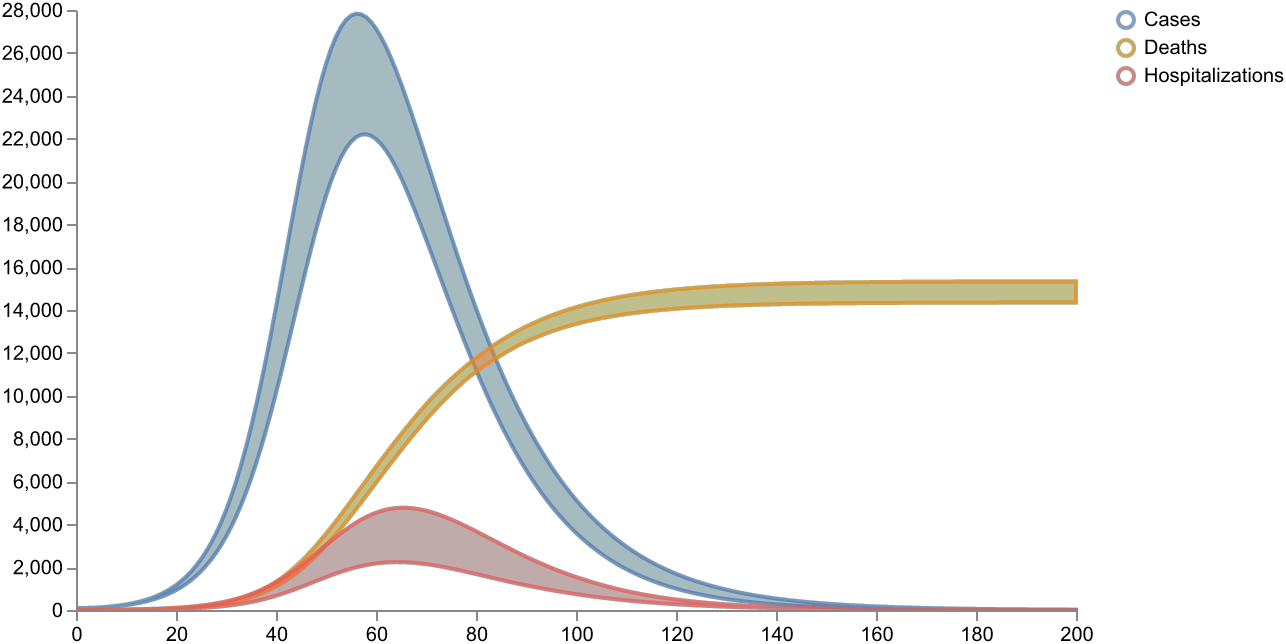

In [41]:
result_sensitivity = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
nice_labels = {
        "cases_observable_state": "Cases",
        "hospitalized_observable_state": "Hospitalizations", 
        "deceased_observable_state": "Deaths"
        }


schema = plots.trajectories(
    result_sensitivity["data"], 
    keep=["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"],
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [42]:

# persistent_δ_param
# persistent_ε_param

[24943.27929688 24587.51757812 23251.08984375 24184.87890625
 20629.65429688 20670.95703125 23904.296875   22305.65429688
 25690.15625    18949.3671875  25791.72265625 23848.078125
 25415.26367188 23338.703125   25805.08398438 25474.390625
 21364.73242188 21953.57421875 20944.08789062 20688.30078125
 20468.70507812 20348.12695312 19709.48046875 19250.61328125
 25670.57421875 22656.20703125 21610.61132812 19026.69726562
 23937.76953125 24422.43945312 23789.89648438 19421.80078125
 19029.3671875  23774.75976562 20436.38867188 22625.02148438
 22431.234375   20196.33007812 20407.5546875  24250.34765625
 25229.48632812 22698.703125   21496.57617188 21511.8125
 18949.5234375  21531.62109375 21957.50195312 21917.66992188
 25464.85351562 19333.90429688 22133.20507812 22030.
 24667.99023438 23209.0390625  23876.33203125 22976.65429688
 24984.70703125 21304.453125   23343.7109375  23195.17773438
 23608.11914062 22667.7265625  24303.00195312 25451.265625
 20712.71289062 23292.34960938 22080.80468

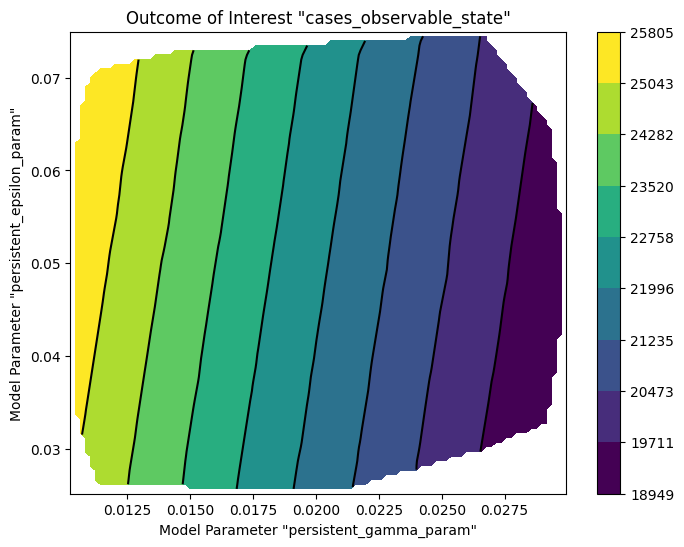

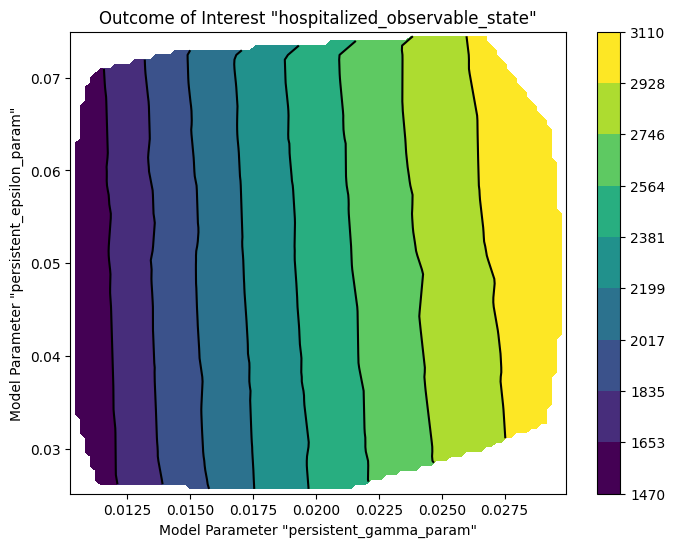

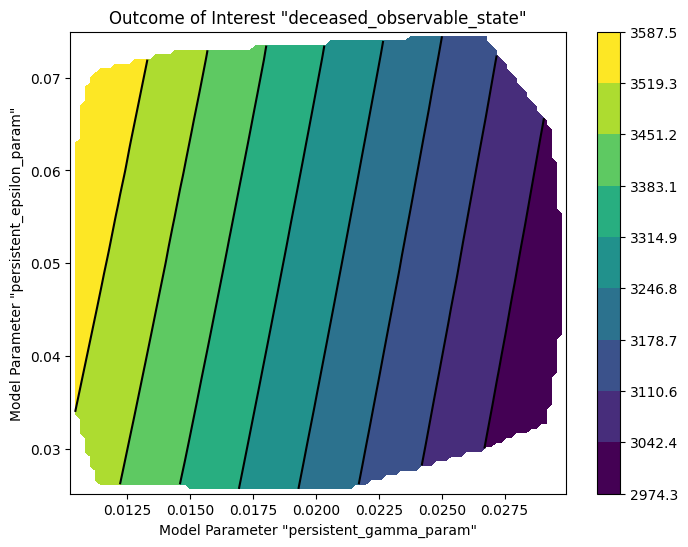

In [43]:
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

d1 = result_sensitivity["data"]
\
def get_contour_plot(d1, x, column_x, column_y, outcome):

    n = d1["sample_id"].max()
    b = np.array([d1[(d1["sample_id"] == i) & (d1["timepoint_id"] == x)][column_x].iloc[0] for i in range(n)])
    rHR = np.array([d1[(d1["sample_id"] == i) & (d1["timepoint_id"] == x)][column_y].iloc[0] for i in range(n)])
    outcomes = np.array([d1[(d1["sample_id"] == i) & (d1["timepoint_id"] == x)][outcome].iloc[0] for i in range(n)])
    print(outcomes)

    xy = np.c_[b, rHR]
    lut2 = LinearNDInterpolator(xy, outcomes)

    # Interpolate to a uniform grid
    m = 100
    x = np.linspace(b.min(), b.max(), m)
    y = np.linspace(rHR.min(), rHR.max(), m)
    xx, yy = np.meshgrid(x, y)

    zz = lut2(xx, yy)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    h1 = ax.contourf(xx, yy, zz, np.linspace(outcomes.min(), outcomes.max(), 10), cmap=plt.cm.viridis.resampled(10 - 1))
    h2 = ax.contour(xx, yy, zz, h1.levels, colors='k')
    __ = fig.colorbar(h1, ax=ax)

    __ = plt.setp(ax, xlabel=f'Model Parameter "{column_x}"', ylabel=f'Model Parameter "{column_y}"', title=f'Outcome of Interest "{outcome}"')

get_contour_plot(d1, 50, "persistent_gamma_param", "persistent_epsilon_param", "cases_observable_state")
get_contour_plot(d1, 50, "persistent_gamma_param", "persistent_epsilon_param", "hospitalized_observable_state")
get_contour_plot(d1, 50, "persistent_gamma_param", "persistent_epsilon_param", "deceased_observable_state")


### 4.2 Decision Maker


In [44]:
# 𝛼 (alpha) r_ID  = 0.01 / 𝑑𝑎𝑦 is the death rate for infected individuals who are not hospitalized
# 𝛽 (beta) r_SE= 0.60 new infections per infected person/day is the transmission rate
# 𝛿 (delta) r_IR= 0.05 / 𝑑𝑎𝑦 is the rate infected individuals recover
# 𝜖 (epsilon) r_VE (I think the diagram in pdf is wrong V goes to E, not I based on the equations)= 0.05 / 𝑑𝑎𝑦 is the rate exposed and vaccinated individuals become infected
# 𝛾 (gamma) r_IH = 0.02 / 𝑑𝑎𝑦 is the rate infected individuals become hospitalized
# 𝜇 (mu) r_HD = 0.02 / 𝑑𝑎𝑦 is the death rate for hospitalized individuals
# 𝜈 (nu) r_SV = 0.005 / 𝑑𝑎𝑦 is the vaccination rate
# 𝜌 (rho) r_HR = 0.10 / 𝑑𝑎𝑦 is the rate hospitalized individuals recover
# 𝜎 (sigma) r_EI = 0.10 / 𝑑𝑎𝑦 is the rate exposed and unvaccinated individuals become infected

In [45]:
model_intervention = "scenerio_3_mo_intervention.json"
start_time = 0.0
end_time = 200.0

seir_model = TemplateModel(
    templates=transitions,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model_intervention, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)


{'cases_observable_state': 'Cases', 'hospitalized_observable_state': 'Hospitalizations', 'deceased_observable_state': 'Deaths'}


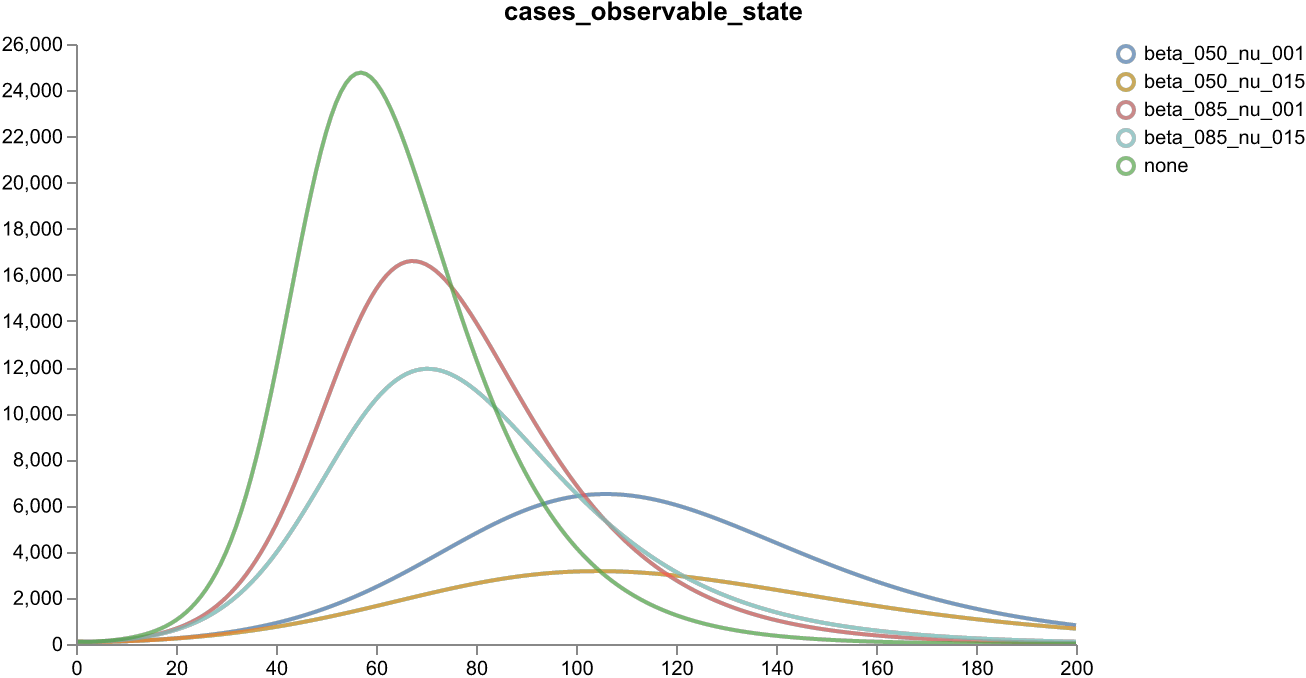

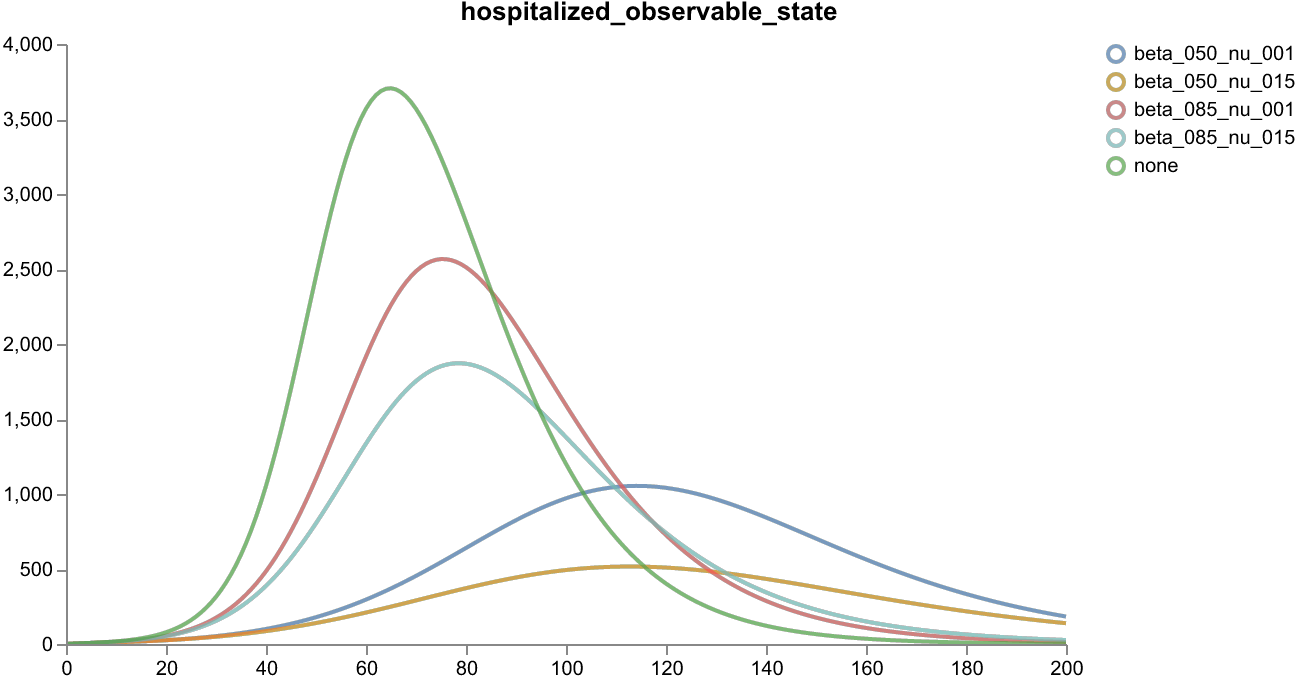

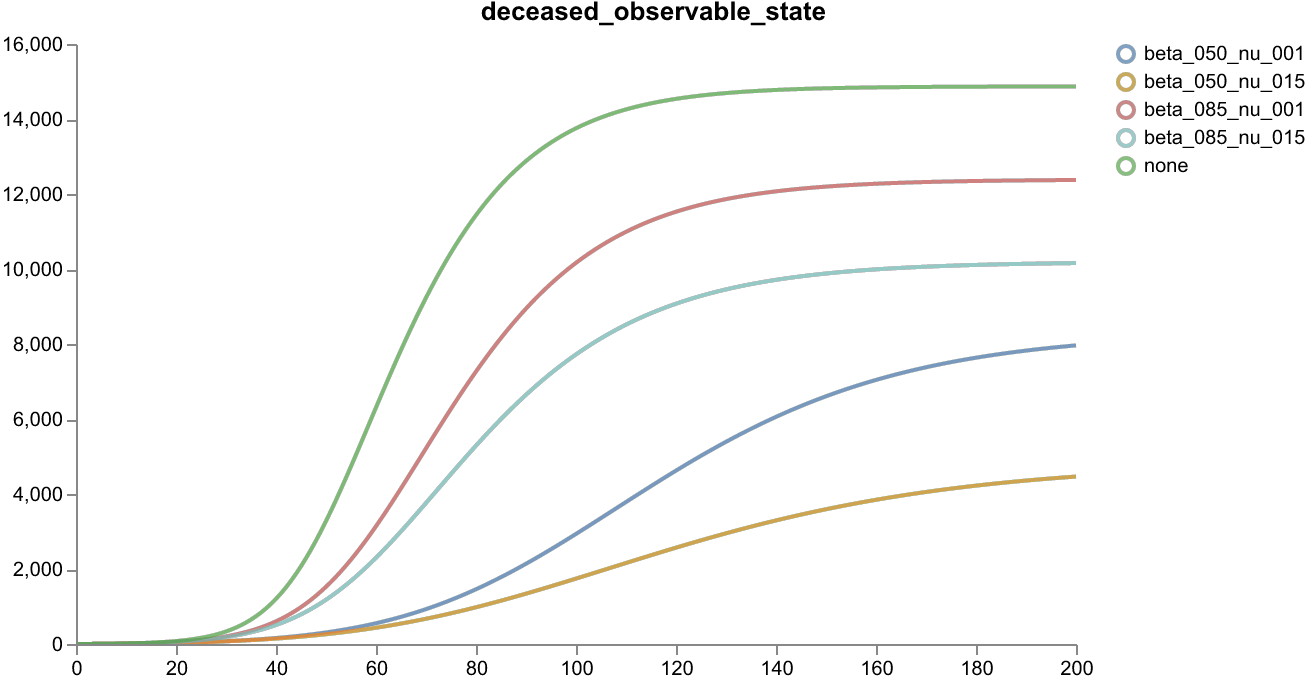

In [46]:
interventions = {
    "none": {},
    "beta_085_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.01)}},
    "beta_050_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.01)}},
    "beta_085_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.015)}},
    "beta_050_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.015)}}
}
new_labels = nice_labels.copy()
results_dict_dist = {}

all_results = pd.DataFrame()
for key, intervention in interventions.items():
    invervention_sample_results = pyciemss.sample(model_intervention, end_time, logging_step_size, num_samples, 
                                                start_time=start_time, 
                                                static_parameter_interventions=intervention)
    # Save results to a DataFrame with intervention-named columns
    all_results["timepoint_id"] = invervention_sample_results["data"]["timepoint_id"]
    all_results["sample_id"] = invervention_sample_results["data"]["sample_id"]
    for label in nice_labels:
        if label in invervention_sample_results["data"].columns:
            new_labels[f"{label}_intervention_{key}"] = key
            all_results[f"{label}_intervention_{key}"] = invervention_sample_results["data"][label]
    
    # Get results at timepoint_id 200 for each observable state
    final_results = invervention_sample_results["data"][invervention_sample_results["data"]["timepoint_id"] == 200]
    intervention_results = {nice_labels[label]: final_results[label].values for label in nice_labels}
    results_dict_dist[f"intervention_{key}"] = intervention_results


print(nice_labels)
# Display separately for each observable state
for state in ["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"]:
    schema = plots.trajectories(
        all_results,
        keep=[col for col in all_results.columns if state in col],
        relabel=new_labels,
        title=f"{state}"
    )
    plots.save_schema(schema, f"_schema_intervention_state.json")
    display(plots.ipy_display(schema, dpi=150))


In [47]:
import pandas as pd



# Calculate the median of the values of the array within the dictionary
median_results = {key: {k: np.round(np.median(v), 2) for k, v in value.items()} for key, value in results_dict_dist.items()}

# Turn the results into a table
median_df = pd.DataFrame(median_results).T
median_df
#

,Cases,Hospitalizations,Deaths
intervention_none,7.75,2.77,14867.67
intervention_beta_085_nu_001,47.27,13.84,12373.40
intervention_beta_050_nu_001,812.00,183.17,7962.66
intervention_beta_085_nu_015,101.37,26.64,10158.21
intervention_beta_050_nu_015,666.24,138.57,4464.87


### 4.3 Decision Maker + Uncertainity at 50 days



In [48]:
model_intervention_distribution = "scenerio_3_mo_intervention_uncertainity.json"
start_time = 0.0
end_time = 50.0

seir_model_dist = TemplateModel(
    templates=transitions,
    parameters=parameters_q1,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model_intervention_distribution, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model_dist), fh, indent=1)


{'cases_observable_state': 'Cases', 'hospitalized_observable_state': 'Hospitalizations', 'deceased_observable_state': 'Deaths'}


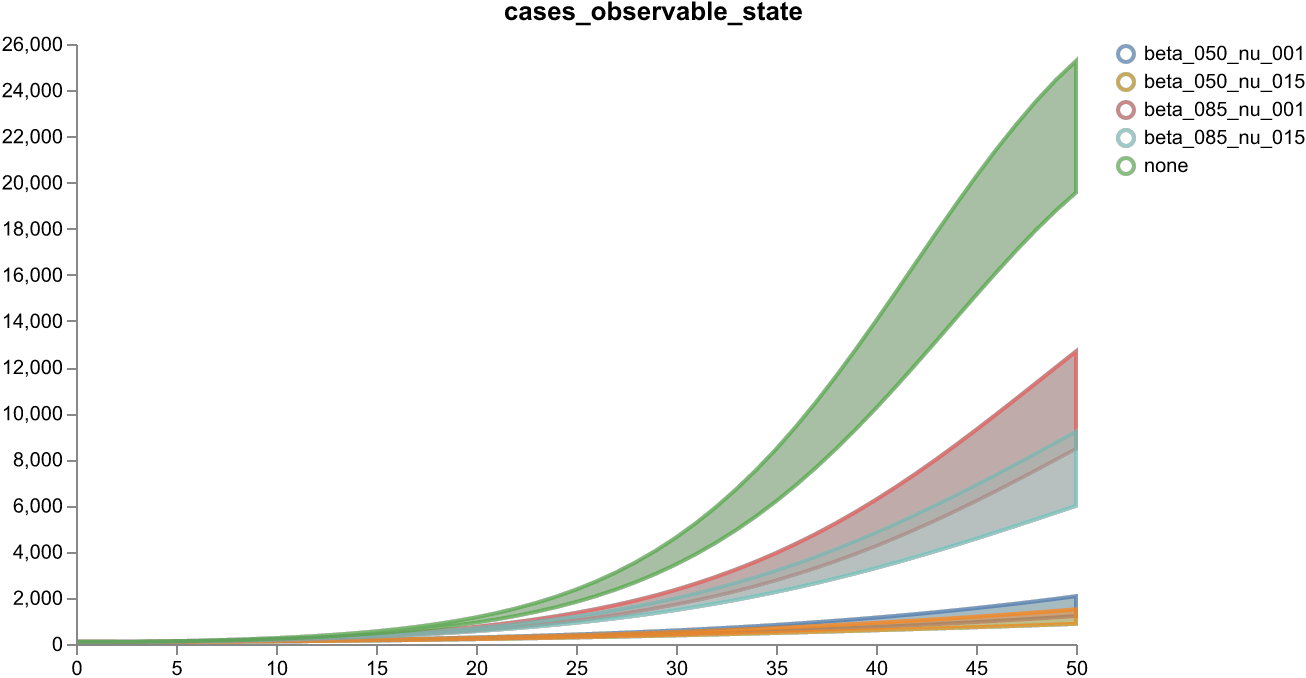

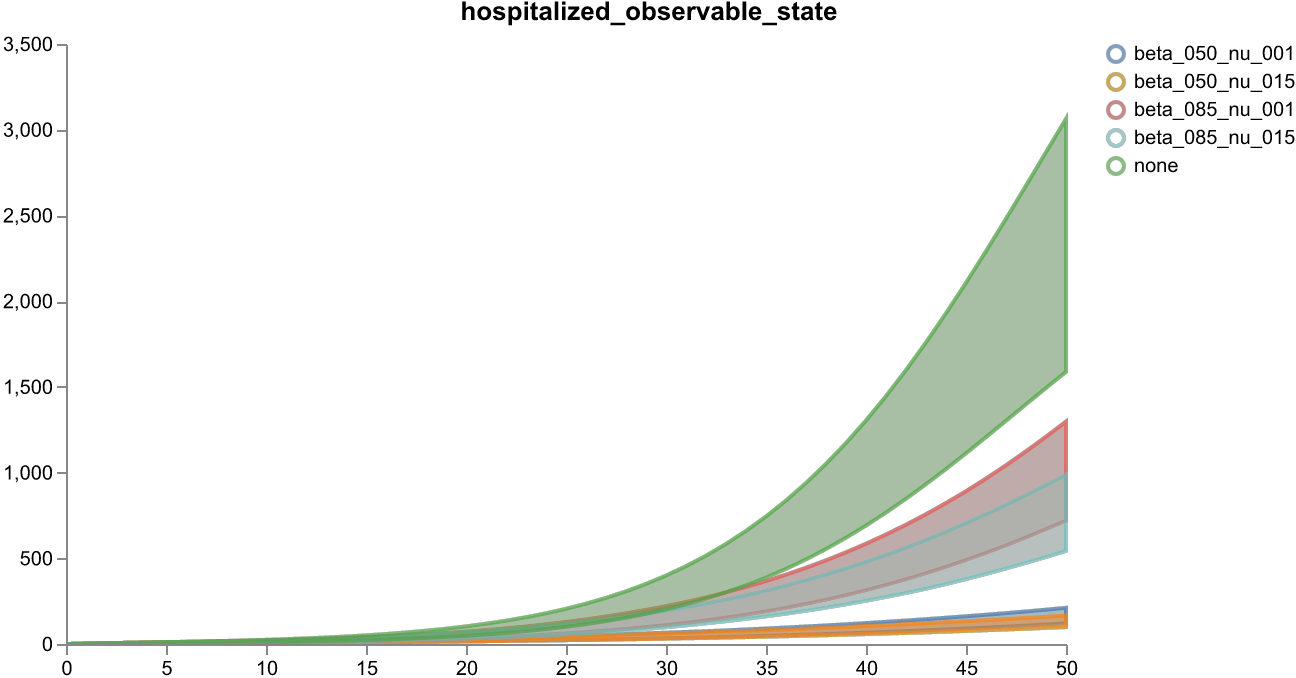

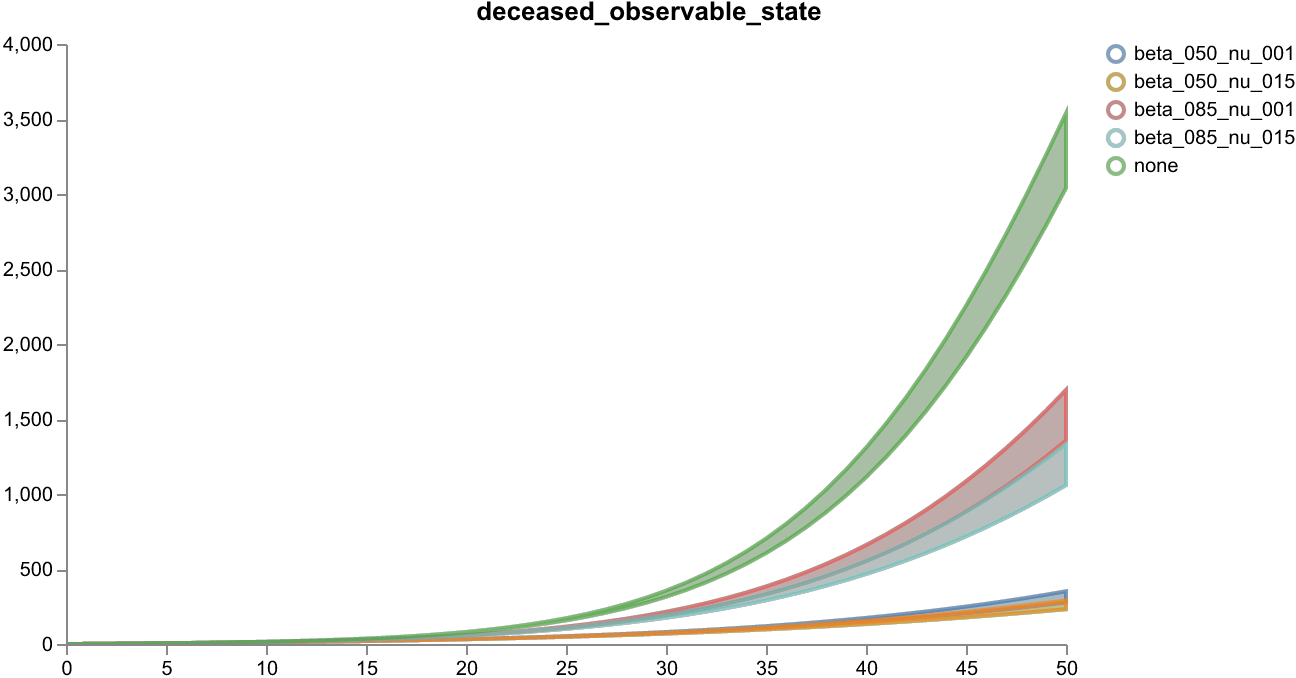

In [49]:

interventions = {
    "none": {},
    "beta_085_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.01)}},
    "beta_050_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.01)}},
    "beta_085_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.015)}},
    "beta_050_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.015)}}
}
nice_labels = {
    "cases_observable_state": "Cases",
    "hospitalized_observable_state": "Hospitalizations", 
    "deceased_observable_state": "Deaths"
}
new_labels = nice_labels.copy()
results_dict_dist = {}

all_results = pd.DataFrame()
for key, intervention in interventions.items():
    invervention_sample_results = pyciemss.sample(model_intervention_distribution, end_time, logging_step_size, num_samples, 
                                                start_time=start_time, 
                                                static_parameter_interventions=intervention)
    # Save results to a DataFrame with intervention-named columns
    all_results["timepoint_id"] = invervention_sample_results["data"]["timepoint_id"]
    all_results["sample_id"] = invervention_sample_results["data"]["sample_id"]
    for label in nice_labels:
        if label in invervention_sample_results["data"].columns:
            new_labels[f"{label}_intervention_{key}"] = key
            all_results[f"{label}_intervention_{key}"] = invervention_sample_results["data"][label]
    
    # Get results at timepoint_id 200 for each observable state
    final_results = invervention_sample_results["data"][invervention_sample_results["data"]["timepoint_id"] == 50]
    intervention_results = {nice_labels[label]: final_results[label].values for label in nice_labels}
    results_dict_dist[f"intervention_{key}"] = intervention_results


print(nice_labels)
# Display separately for each observable state
for state in ["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"]:
    schema = plots.trajectories(
        all_results,
        keep=[col for col in all_results.columns if state in col],
        relabel=new_labels,
        title=f"{state}"
    )
    plots.save_schema(schema, f"_schema_intervention_state.json")
    display(plots.ipy_display(schema, dpi=150))

In [50]:
import pandas as pd


results_dict_dist
# Calculate the median of the values of the array within the dictionary
median_results = {key: {k: np.round(np.median(v), 2) for k, v in value.items()} for key, value in results_dict_dist.items()}

# Turn the results into a table
median_df = pd.DataFrame(median_results).T
median_df
#

,Cases,Hospitalizations,Deaths
intervention_none,22138.20,2392.54,3278.37
intervention_beta_085_nu_001,10606.34,1069.67,1532.60
intervention_beta_050_nu_001,1580.13,173.13,311.06
intervention_beta_085_nu_015,7340.53,803.71,1175.99
intervention_beta_050_nu_015,1139.27,140.35,259.61


### 4.4 Horizon Scanning Maker


In [51]:
scenario_3_total_popp_seid =800000 # US Census Bureau

initial_exposed = 0
initial_deaths = 0
initial_infected = 100
initial_susceptible = 79900
initial_ccases = 100


In [52]:
c_seid = {
    'S': Concept(name='S', units=person_units()),  # Susceptible
    'E': Concept(name='E', units=person_units()),  # Exposed
    'I': Concept(name='I', units=person_units()),  # Infectious
    'D': Concept(name='D', units=person_units()),  # Recovered
    'C_c': Concept(name="C_c", units=person_units())  # Cumulative Cases
}

for concept in c_seid:
    c_seid[concept].name = concept


In [53]:
parameters_seid = {
    'beta': Parameter(name='beta', value=sympy.Float(0.5), units=per_day_units()),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(scenario_3_total_popp_seid), units=person_units()),  
    'sigma': Parameter(name='sigma', value=sympy.Float(0.15), units=per_day_units()),  # Rate exposed and unvaccinated individuals become infected
    'mu': Parameter(name='mu', value=sympy.Float(0.075), units=per_day_units()),  # Death rate for infected individuals 
}

parameters_seid_full_distribution = {
    'beta': Parameter(name='beta', value=sympy.Float(0.5), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .2,
                                                            'maximum': .8})),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(scenario_3_total_popp_seid), units=person_units()),  
    'sigma': Parameter(name='sigma', value=sympy.Float(0.15), units=per_day_units()),  # Rate exposed and unvaccinated individuals become infected
    'mu': Parameter(name='mu', value=sympy.Float(0.075), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.05,
                                                            'maximum':  0.10})),  # Death rate for hospitalized individuals
}
parameters_seid_mu_max = parameters_seid.copy()
parameters_seid_mu_max['mu'] = Parameter(name='mu', value=sympy.Float(.09), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .09,
                                                            'maximum': .11}))

parameters_seid_beta_max = parameters_seid.copy()
parameters_seid_beta_max['beta'] = Parameter(name='beta', value=sympy.Float(.85), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .85,
                                                            'maximum': .9}))

parameters_seid_beta_max_mu_max = parameters_seid.copy()
parameters_seid_beta_max_mu_max['beta'] = Parameter(name='beta', value=sympy.Float(.85), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .85,
                                                            'maximum': .9}))
parameters_seid_beta_max_mu_max['mu'] = Parameter(name='mu', value=sympy.Float(.09), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .09,
                                                            'maximum': .11}))

parameters_seid_beta_max_mu_min = parameters_seid.copy()
parameters_seid_beta_max_mu_min['beta'] = Parameter(name='beta', value=sympy.Float(.85), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .85,
                                                            'maximum': .9}))
parameters_seid_beta_max_mu_min['mu'] = Parameter(name='mu', value=sympy.Float(.04), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .04,
                                                            'maximum': .06}))


parameters_seid_mu_min = parameters_seid.copy()
parameters_seid_beta_max_mu_min['mu'] = Parameter(name='mu', value=sympy.Float(.04), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .04,
                                                            'maximum': .06}))

In [54]:

initials_seid = {
    "S": Initial(concept=c_seid["S"], expression=initial_susceptible),
    "E": Initial(concept=c_seid["E"], expression=initial_exposed),
    "I": Initial(concept=c_seid["I"], expression=initial_infected),
    "D": Initial(concept=c_seid["D"], expression=initial_deaths),
    "C_c": Initial(concept=c_seid["C_c"], expression=initial_ccases),
}


In [55]:
##### S -> E beta #
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I / N
)


#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=sigma*E
)




#### I -> D
id = NaturalConversion(
    subject=c['I'],
    outcome=c['D'],
    rate_law=mu*I
)



### Cumulative compartments
# Cumulative Cases
### Cumulative compartments
# Cumulative Cases
ccases = ControlledProduction(
    controller=c['E'],
    outcome=c['C_c'],
    rate_law=sigma*E
)


# List of all transitions
transitions_seid = [se, ei, id, ccases]



In [56]:
observables_seid = {
    'cases': Observable(name='cases', expression=I),
    'deceased': Observable(name='deceased', expression=D),
    'c_cases': Observable(name='c_cases', expression=C_c)
}

In [57]:
model_seid = "scenerio_3_mo_seid.json"
num_iterations = 100
num_samples = 100
start_time = 0.0
end_time = 200.0
logging_step_size = 1.0

solution_mapping = [lambda x : x]

seir_model = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)

seir_model_full_distribution = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid_full_distribution,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)

seir_model_beta_max = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid_beta_max,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)

seir_model_mu_max = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid_mu_max,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)

seir_model_beta_max_mu_max = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid_beta_max_mu_max,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)

seir_model_mu_min = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid_mu_min,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)

seir_model_beta_max_mu_min = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid_beta_max_mu_min,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)
# Save as JSON
with open(model_seid, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

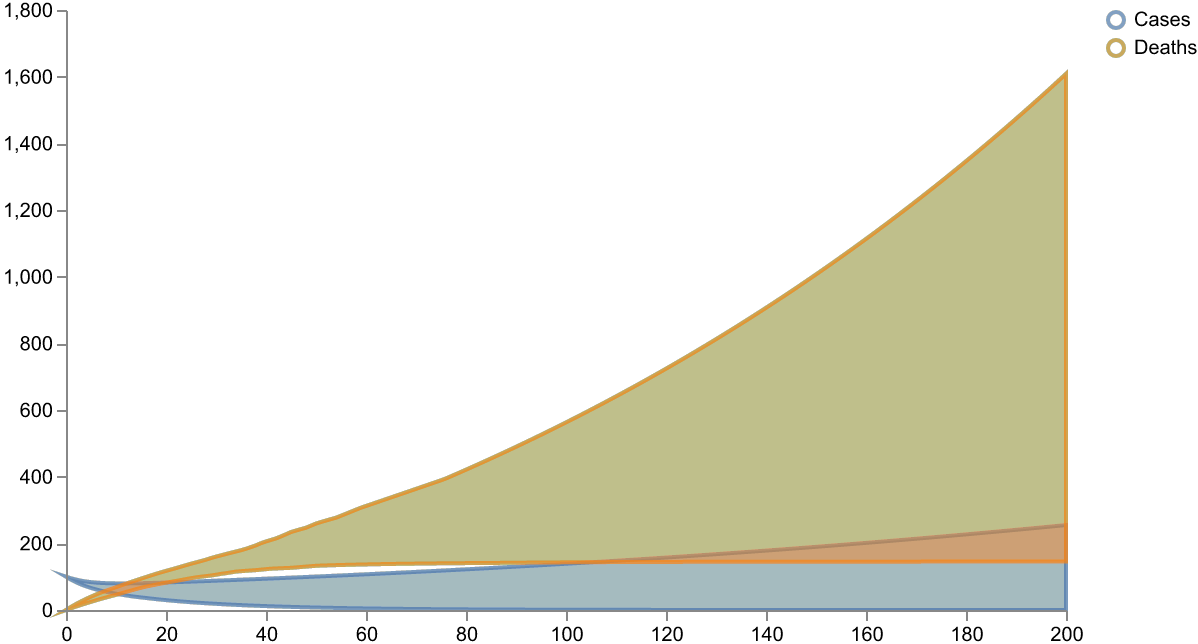

In [58]:
result1 = pyciemss.sample(seir_model_full_distribution, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
nice_labels = {
        "cases_observable_state": "Cases",
        "deceased_observable_state": "Deaths"
        }


schema = plots.trajectories(
    result1["data"], 
    keep=["cases_observable_state", "deceased_observable_state"],
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

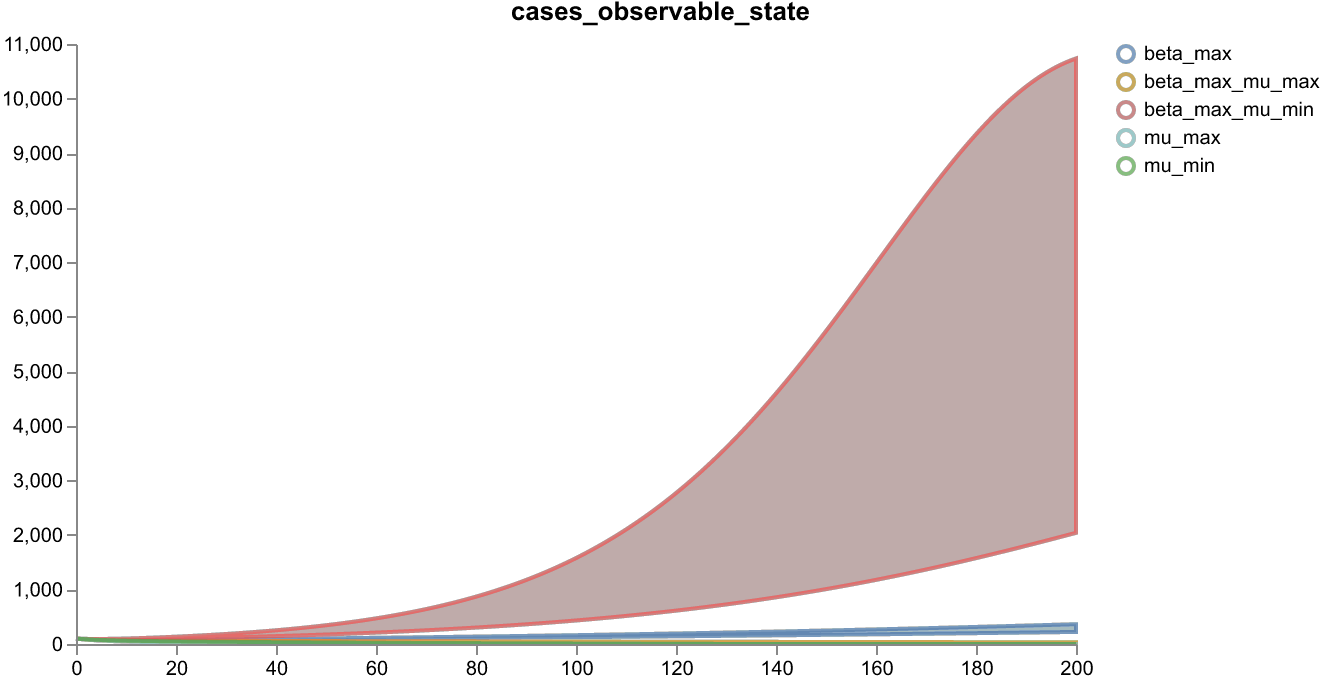

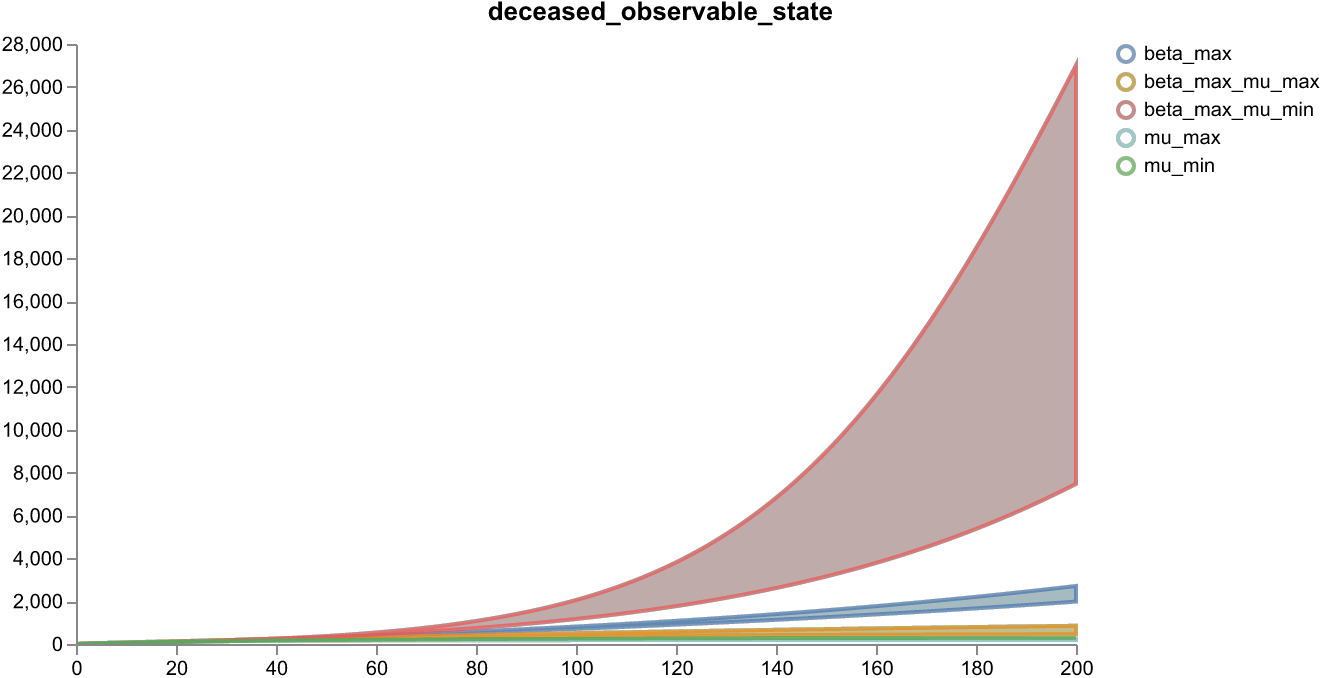

In [59]:
models = {"mu_max": seir_model_mu_max, "beta_max": seir_model_beta_max, "beta_max_mu_max": seir_model_beta_max_mu_max, "beta_max_mu_min": seir_model_beta_max_mu_min, "mu_min": seir_model_mu_min}
nice_labels = {
    "cases_observable_state": "Cases",
    "deceased_observable_state": "Deaths"
}
labels = nice_labels.copy()
results_dict_horizon = {}

all_results = pd.DataFrame()
for key, model in models.items():
    invervention_sample_results = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                                                start_time=start_time)
    # Save results to a DataFrame with intervention-named columns
    all_results["timepoint_id"] = invervention_sample_results["data"]["timepoint_id"]
    all_results["sample_id"] = invervention_sample_results["data"]["sample_id"]
    for label in nice_labels:
        if label in invervention_sample_results["data"].columns:
            all_results[f"{label}_intervention_{key}"] = invervention_sample_results["data"][label]
            labels[f"{label}_intervention_{key}"] = key
    # Get results at timepoint_id 200 for each observable state
    final_results = invervention_sample_results["data"][invervention_sample_results["data"]["timepoint_id"] == 200]
    intervention_results = {nice_labels[label]: final_results[label].values for label in nice_labels}
    results_dict_horizon[f"intervention_{key}"] = intervention_results



# Display separately for each observable state
for state in ["cases_observable_state", "deceased_observable_state"]:
    schema = plots.trajectories(
        all_results,
        keep=[col for col in all_results.columns if state in col],
        relabel=labels,
        title=f"{state}"
    )
    plots.save_schema(schema, f"_schema_intervention_state.json")
    display(plots.ipy_display(schema, dpi=150))

In [60]:
import pandas as pd


# Calculate the median of the values of the array within the dictionary
median_results = {key: {k: np.int(np.median(v)) for k, v in value.items()} for key, value in results_dict_horizon.items()}

# Turn the results into a table
median_df = pd.DataFrame(median_results).T
median_df
#

/var/folders/vn/q5vrjvfn60bfsnnd058cb6ww0000gn/T/ipykernel_53609/2772124271.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  median_results = {key: {k: np.int(np.median(v)) for k, v in value.items()} for key, value in results_dict_horizon.items()}


,Cases,Deaths
intervention_mu_max,0,199
intervention_beta_max,286,2322
intervention_beta_max_mu_max,10,587
intervention_beta_max_mu_min,5340,14862
intervention_mu_min,1,291
